In [1]:
# Imports

import nltk
import requests
import time
import pandas as pd
import os
import re
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import streamlit as st
import torch
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_hub as hub
import nlpaug.augmenter.word as naw
import random

from torch.utils.tensorboard import SummaryWriter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoTokenizer
from langchain import PromptTemplate, LLMChain
from dotenv import find_dotenv, load_dotenv
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorboard.plugins import projector
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence
from tensorboard.plugins import projector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model, Sequential
from scipy.spatial.distance import euclidean, cosine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nlpaug.util import Action

# Set random seed
np.random.seed(42)

# Load environment variables
load_dotenv()

/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("best_of")
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydan

True

In [2]:
# ---------- Functions ---------- #

# ---------- Loading the dataset ---------- #

df = pd.read_csv('yelp_reviews.csv')

df.drop_duplicates(inplace=True)
df.dropna(subset=['text', 'rating', 'location'], inplace=True)

In [22]:
# ---------- Preprocessing ---------- #

# Translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].astype(str)

# Check if text contains Chinese characters
def contains_chinese(text):
    return bool(re.search('[\u4e00-\u9fff]', text))

# Translation function (from Chinese to English)
def translate_text(text):
    if contains_chinese(text):
        return translator(text)[0]['translation_text']
    else:
        return text
    
# Lemmatisation & Tokenisation function
def tokenisation(reviews, allowed_postags=["NOUN", "ADJ", "VERBS", "ADV"]):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    reviews_out = []
    tokens = []

    for review in reviews:
        doc = nlp(review) 
        reviews_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words]))
    
    for text in reviews_out:
        new = gensim.utils.simple_preprocess(text, deacc=False) # We do not remove the accent marks because we deem them important for French restaurants reviews
        tokens.append(new)

    return tokens

# Preprocessing function
def preprocessing(text):
    # Corrected spelling on lower case text
    corrected_text = str(TextBlob(text.lower()).correct())

    # Translation
    cleaned_text = translate_text(str(corrected_text))

    return cleaned_text

# Apply preprocessing and tokenisation
df['cleaned_text'] = df['text'].apply(preprocessing)
df['tokens'] = tokenisation(df['cleaned_text'])

In [ ]:
# Summarisation

max_length_coef = 1.5
min_length_coef = 2

summariser = pipeline("summarization", model="facebook/bart-large-cnn")
summarised_text = df['text'].apply(lambda x: summariser(x, max_length=round(len(x)/max_length_coef), min_length=round(len(x)/min_length_coef), do_sample=False))
df['summarised_text'] = summarised_text.apply(lambda x: x[0]['summary_text'])

In [39]:
# ---------- Highlighting frequent words ---------- #

review_frequent_words = {}

def get_frequency(restaurant_id):

    # Word Frequency Analysis
    all_words = [word for tokens in df[df['restaurant_id'] == restaurant_id]['tokens'] for word in tokens]
    word_freq = Counter(all_words)

    # N-gram Analysis
    bigrams = ngrams(all_words, 2)
    bigram_freq = Counter(bigrams)

    # Tri-gram Analysis
    trigrams = ngrams(all_words, 3)
    trigram_freq = Counter(trigrams)

    return [word_freq, bigram_freq, trigram_freq]

for restaurant_id in df['restaurant_id']:
    review_frequent_words[restaurant_id] = get_frequency(restaurant_id)

review_frequent_words_df = pd.DataFrame.from_dict(review_frequent_words, orient='index', columns=['word_freq', 'bigram_freq', 'trigram_freq'])
review_frequent_words_df

,word_freq,bigram_freq,trigram_freq
1,"{'[': 10, ''': 204, 'a': 41, 'm': 17, 'z': 2, ...","{('[', '''): 10, (''', 'a'): 8, ('a', 'm'): 5,...","{('[', ''', 'a'): 2, (''', 'a', 'm'): 2, ('a',..."
2,"{'[': 10, ''': 212, 'h': 16, 'e': 75, 'a': 44,...","{('[', '''): 10, (''', 'h'): 6, ('h', 'e'): 3,...","{('[', ''', 'h'): 1, (''', 'h', 'e'): 2, ('h',..."
3,"{'[': 10, ''': 190, 'r': 49, 'e': 76, 'v': 15,...","{('[', '''): 10, (''', 'r'): 9, ('r', 'e'): 12...","{('[', ''', 'r'): 3, (''', 'r', 'e'): 6, ('r',..."
4,"{'[': 10, ''': 200, 'p': 18, 'r': 40, 'e': 67,...","{('[', '''): 10, (''', 'p'): 11, ('p', 'r'): 2...","{('[', ''', 'p'): 1, (''', 'p', 'r'): 2, ('p',..."
5,"{'[': 10, ''': 194, 'g': 19, 'r': 35, 'e': 85,...","{('[', '''): 10, (''', 'g'): 5, ('g', 'r'): 2,...","{('[', ''', 'g'): 1, (''', 'g', 'r'): 2, ('g',..."
...,...,...,...
58,"{'[': 10, ''': 188, 'd': 22, 'e': 89, 'm': 20,...","{('[', '''): 10, (''', 'd'): 6, ('d', 'e'): 5,...","{('[', ''', 'd'): 1, (''', 'd', 'e'): 2, ('d',..."
59,"{'[': 10, ''': 198, 't': 48, 'e': 76, 'n': 47,...","{('[', '''): 10, (''', 't'): 9, ('t', 'e'): 8,...","{('[', ''', 't'): 1, (''', 't', 'e'): 1, ('t',..."
60,"{'[': 10, ''': 182, 's': 36, 'e': 84, 'r': 47,...","{('[', '''): 10, (''', 's'): 16, ('s', 'e'): 1...","{('[', ''', 's'): 2, (''', 's', 'e'): 6, ('s',..."
61,"{'[': 10, ''': 204, 'k': 8, 'i': 59, 'd': 31, ...","{('[', '''): 10, (''', 'k'): 3, ('k', 'i'): 5,...","{('[', ''', 'k'): 1, (''', 'k', 'i'): 3, ('k',..."


In [17]:
# ---------- Topic Modelling ---------- #

# We convert the tokens into tuples where we'll have the word index (its placement on the map) and its frequency
id2word = corpora.Dictionary(df['tokens'])
corpus = [id2word.doc2bow(text) for text in df['tokens']]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=10)
pyLDAvis.display(vis)

/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [3]:
def get_topic_distribution(lda_model, bow):
    return lda_model.get_document_topics(bow, minimum_probability=0)

df['topic_distribution'] = [get_topic_distribution(lda_model, corpus[i]) for i in range(len(df))]

def get_top_topics(topic_distribution, num_topics=5):
    # Sort the topics by probability and select the top ones
    return sorted(topic_distribution, key=lambda x: x[1], reverse=True)[:num_topics]

df['top_topics'] = df['topic_distribution'].apply(lambda x: get_top_topics(x, 11 - 1))

def label_topics(topic_list, lda_model):
    labels = []
    for topic_id, _ in topic_list:
        # Get the top words in the topic
        words = lda_model.show_topic(topic_id, 5)
        # Create a label (e.g., by joining the top words)
        label = [word for word, prob in words]
        labels.append(label)
    return labels

def topicise(labels, label_dict):
    topics = []

    for topic_list in labels:
        for key, value in label_dict.items():
            if set(topic_list) == set(value):
                topics.append(key)

    return topics

label_dict = {
    'Quality of Food & Service' : ['service', 'food', 'restaurant', 'good', 'great'],
    'French Dining Experience' : ['dinner', 'meal', 'french', 'reservation', 'little'],
    'Atmosphere' : ['speak', 'dining', 'menu', 'experience', 'soup'],
    'Price' : ['course', 'table', 'thing', 'life', 'party'],
    'Special Occasions' : ['birthday', 'time', 'family', 'really', 'warm'],
    'Ambience' : ['experience', 'overall', 'kiss', 'attentive', 'fantastic'],
    'Dining Experience' : ['experience', 'overall', 'kiss', 'attentive', 'fantastic'],
    'Staff' : ['year', 'last', 'time', 'first', 'second'],
    'Menu' : ['atmosphere', 'area', 'bit', 'high', 'mummy'],
    'Drinks' : ['way', 'incredible', 'class', 'wall', 'mood'] 
}

df['top_topic_labels'] = df['top_topics'].apply(lambda x: label_topics(x, lda_model))
df['topics'] = df['top_topic_labels'].apply(lambda x: topicise(x, label_dict))
df.drop(columns=['topic_distribution', 'top_topics'], inplace=True)

NameError: name 'lda_model' is not defined

## Word2vec

In [3]:
# Phrases alogrithm

min_count = 3
threshold = 5

phrases = Phrases(df['tokens'], min_count=min_count, threshold=threshold)
phraser = Phraser(phrases)

df['bigrams'] = phraser[ df['tokens']]
df['trigrams'] = phraser[df['bigrams']]

In [4]:
vector_size = 100
window = 5
min_count = 1
workers = 4

# Training the model
word2vec_model = Word2Vec(sentences=[df['bigrams']], vector_size=vector_size, window=window, min_count=min_count, workers=workers)

# Save the model
word2vec_model.save("word2vec.model")

Exception in thread Thread-7 (_worker_loop):
Traceback (most recent call last):
  File "/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gensim/models/word2vec.py", line 1166, in _worker_loop
    tally, raw_tally = self._do_train_job(data_iterable, alpha, thread_private_mem)
  File "/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gensim/models/word2vec.py", line 957, in _do_train_job
    tally += train_batch_cbow(self, sentences, alpha, work, neu1, self.compute_loss)
  File "gensim/models/word2vec_inner.pyx", line 638, in gensim.models.word2vec_inner.train_batch_cbow
  File "/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.

In [ ]:
# file_name = "word2vec.model"
# model = gensim.models.keyedvectors.KeyedVectors.load(file_name)

from gensim.models import Word2Vec

model = Word2Vec.load("word2vec.model")

def vectorize_model(sent, model):
    vector_size = model.vector_size
    model_res = np.zeros(vector_size)
    ctr = 0
    for word in sent:
        if word in model.wv.key_to_index:
            ctr += 1
            model_res += model.wv[word]
    if ctr > 0:
        model_res = model_res / ctr
    return model_res

df['vectors'] = df['tokens'].apply(lambda x: vectorize_model(x, model))

X = df['vectors'].to_list()
y = df['sentiment'].to_list()

test_size = 0.2
stratify_value = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,stratify=stratify_value, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)

predicted = classifier.predict(X_test)

print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='micro'))  # Change average to 'micro', 'macro', 'weighted', or None
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='micro'))  # Change average to 'micro', 'macro', 'weighted', or None

Logistic Regression Accuracy: 0.782258064516129
Logistic Regression Precision: 0.782258064516129
Logistic Regression Recall: 0.782258064516129


["'", ' ', ',', 'e', 'a', 'r', 'i', 't', 'n', 'o', 'l', 's', 'c', 'd', 'u', 'p', 'f', 'g', 'h', 'm', 'y', '[', ']', 'v', 'b', 'w', 'k', 'x', 'z', 'q', 'j', 'û', 'é']


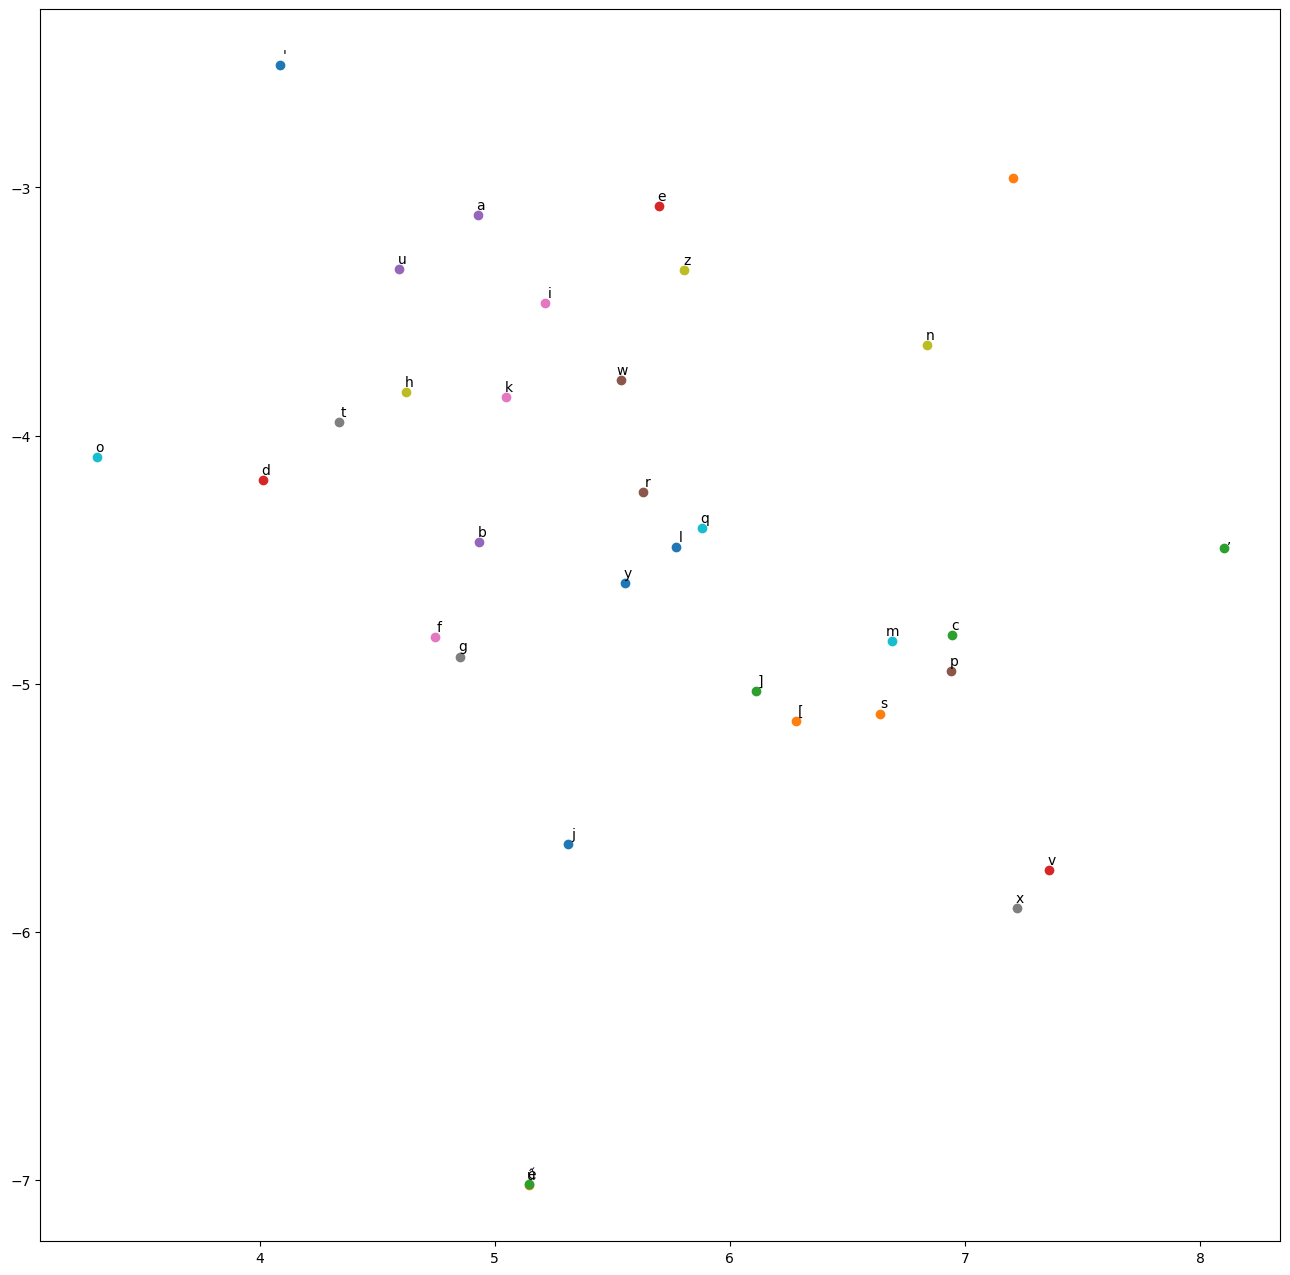

In [133]:
def tsne_plot(model):
    vocab = model.wv.index_to_key

    print(vocab)

    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in vocab:
        tokens.append(model.wv[word])
        labels.append(word)
        #print(tokens)
        #print(labels)
    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)


    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

tsne_plot(model)

In [8]:
file_name = "word2vec.model"
model = gensim.models.keyedvectors.KeyedVectors.load(file_name)

max_size = len(model.wv.index_to_key)-1

w2v = np.zeros((max_size,model.vector_size))

if not os.path.exists('projections'):
    os.makedirs('projections')
    
with open("projections/metadata.tsv", 'w+') as file_metadata:
    
    for i, word in enumerate(model.wv.index_to_key[:max_size]):
        
        #store the embeddings of the word
        w2v[i] = model.wv[word]
        
        #write the word to a file 
        file_metadata.write(word + '\n')

tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

sess.run(tf.compat.v1.global_variables_initializer())

saver = tf.compat.v1.train.Saver()
writer = tf.compat.v1.summary.FileWriter('projections', sess.graph)
config = projector.ProjectorConfig()
embed= config.embeddings.add()

embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)
saver.save(sess, 'projections/model.ckpt', global_step=max_size)

2024-01-20 14:44:11.424838: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-20 14:44:11.424875: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-20 14:44:11.424886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-20 14:44:11.427800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-20 14:44:11.430655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-20 14:44:11.463036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


'projections/model.ckpt-1457'

In [9]:
def semantic_search(query_word, model, topn=10):
    query_vector = model.wv[query_word]
    all_words = model.wv.index_to_key

    # Calculate cosine distance between query and all other words
    distances = {word: cosine(query_vector, model.wv[word]) for word in all_words}
    
    # Sort words by distance (lower is more similar)
    sorted_words = sorted(distances, key=distances.get)

    # Return the topn closest words
    return sorted_words[:topn]

# Example usage
search_results = semantic_search('wine', word2vec_model)

search_results

['wine',
 'food',
 'dinner',
 'french',
 'truly',
 'great',
 'service',
 'place',
 'old',
 'good']

We've decided to go with this: BERT for Text Classification: Given its context-aware nature and superior performance in understanding nuances, BERT is generally the better choice for text classification.
Word2Vec for Semantic Search: For semantic search tasks, Word2Vec's efficiency and effectiveness in finding similar words make it a strong choice.

## BERT

In [143]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# Load the tokenizer and model
tokeniser = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

def sentiment_score(review):
    tokens = tokeniser.encode(review, return_tensors="pt")
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

# Example usage
example_sentence = 'It was great, I will come back again.'
sentiment_probabilities = sentiment_score(example_sentence)

# Apply to DataFrame
df['sentiment'] = df['text'].apply(lambda x: sentiment_score(x))


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [161]:
df

,text,rating,location,tokens,cleaned_text,top_topic_labels,topics,restaurant_id,sentiment
0,Robyn gave amazing service! So attentive and f...,5,Los Angeles,"[amazing, service, attentive, friendly, stuff,...",robin gave amazing service! so attentive and f...,"[['experience', 'overall', 'kiss', 'attentive'...","['Ambience', 'Dining Experience', 'Quality of ...",1,3
1,Headed downtown on a Thursday evening for a Ki...,5,Los Angeles,"[downtown, evening, king, game, time, dinner, ...",headed downtown on a thursday evening for a ki...,"[['course', 'table', 'thing', 'life', 'party']...","['Price', 'Quality of Food & Service', 'Staff'...",1,2
2,"Been here a few times, in just recent weeks. T...",4,Los Angeles,"[time, recent, week, visit, rooftop, bar, time...","been here a few times, in just recent weeks. t...","[['birthday', 'time', 'family', 'really', 'war...","['Special Occasions', 'Quality of Food & Servi...",1,2
3,Service is fast. Staff is friendly. The food i...,5,Los Angeles,"[service, fast, staff, friendly, food, whole, ...",service is fast. staff is friendly. the food i...,"[['service', 'food', 'restaurant', 'good', 'gr...","['Quality of Food & Service', 'Special Occasio...",1,3
4,Walked by and asked to see a menu. Very helpfu...,3,Los Angeles,"[menu, helpful, staff, french, concept, try, a...",walked by and asked to see a menu. very helpfu...,"[['service', 'food', 'restaurant', 'good', 'gr...","['Quality of Food & Service', 'Atmosphere', 'F...",1,3
...,...,...,...,...,...,...,...,...,...
613,The Steak Tartare is absolutely yummy! Just as...,5,Phoenix,"[tartar, absolutely, mummy, waiter, drop, bran...",the speak tartar is absolutely mummy! just ask...,"[['service', 'food', 'restaurant', 'good', 'gr...","['Quality of Food & Service', 'French Dining E...",62,3
614,The culinary journey begins right at your tabl...,5,Miami,"[urinary, journey, right, table, fresh, potato...",the urinary journey begins right at your table...,"[['course', 'table', 'thing', 'life', 'party']...","['Price', 'Quality of Food & Service', 'Atmosp...",62,3
615,"Very nice ambiance. We went there at night, an...",4,New York City,"[nice, alliance, night, inside, warm, lighting...","very nice alliance. we went there at night, an...","[['service', 'food', 'restaurant', 'good', 'gr...","['Quality of Food & Service', 'Drinks', 'Speci...",62,3
616,M. whatever ... this is a hard pass.... I know...,1,New York City,"[hard, pass, short, rude, thing, bartender, mo...",m. whatever ... this is a hard pass.... i know...,"[['service', 'food', 'restaurant', 'good', 'gr...","['Quality of Food & Service', 'Drinks', 'Frenc...",62,1


In [270]:
def push_new_reviews(df):
    # Record original data types
    original_dtypes = df.dtypes

    sentiment_1_rows = df[df['sentiment'] == df['sentiment'].value_counts().index[1]]
    sentiment_2_rows = df[df['sentiment'] == df['sentiment'].value_counts().index[2]]
    
    for i in range(df['sentiment'].value_counts().iloc[0] - df['sentiment'].value_counts().iloc[1] - 1):
        random_row = random.choice(sentiment_1_rows.index)
        target_row = df.loc[random_row].copy()  # Make a copy of the selected row
        
        new_review = generate_new_reviews(target_row['cleaned_text'])
        target_row['cleaned_text'] = preprocessing(new_review[0])

        # Convert target_row to DataFrame and transpose
        new_row_df = pd.DataFrame(target_row).transpose()

        # Set data types explicitly
        for col in new_row_df.columns:
            new_row_df[col] = new_row_df[col].astype(original_dtypes[col])

        df = pd.concat([df, new_row_df], ignore_index=True)

    for i in range(df['sentiment'].value_counts().iloc[0] - df['sentiment'].value_counts().iloc[2] - 1):
        random_row = random.choice(sentiment_2_rows.index)
        target_row = df.loc[random_row].copy()  # Make a copy of the selected row
        
        new_review = generate_new_reviews(target_row['cleaned_text'])
        target_row['cleaned_text'] = preprocessing(new_review[0])

        # Convert target_row to DataFrame and transpose
        new_row_df = pd.DataFrame(target_row).transpose()

        # Set data types explicitly
        for col in new_row_df.columns:
            new_row_df[col] = new_row_df[col].astype(original_dtypes[col])

        df = pd.concat([df, new_row_df], ignore_index=True)
        
    return df

generated_df = push_new_reviews(df)
generated_df = generated_df.sample(frac=1, random_state=42).reset_index(drop=True)

### Tensorboard

Should we add a tensorboard?

## TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(generated_df['cleaned_text'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, generated_df['sentiment'], test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

def classify_review(review_text):
    # Preprocess the review_text similar to your training data preprocessing
    preprocessed_text = preprocessing(review_text)  # Implement this function based on your preprocessing steps
    
    # Transform the review text to TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([preprocessed_text])
    
    # Predict the label
    predicted_label = classifier.predict(tfidf_features)
    
    return predicted_label

classify_review("This is a great restaurant! I loved the food and the service was amazing.")


              precision    recall  f1-score   support

           1       0.95      0.97      0.96       102
           2       0.91      0.96      0.93       102
           3       0.94      0.85      0.89        85

    accuracy                           0.93       289
   macro avg       0.93      0.93      0.93       289
weighted avg       0.93      0.93      0.93       289



array([3])

In [ ]:
from sklearn.pipeline import make_pipeline
import joblib

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42))

# Fit the pipeline with your data
pipeline.fit(generated_df['cleaned_text'], generated_df['sentiment'])

# Save the pipeline
joblib.dump(pipeline, 'review_classification_pipeline.joblib')

## Tensorboard

In [27]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import tensorflow as tf
from tensorboard.plugins import projector

# Assuming X_tfidf is your TF-IDF matrix
svd = TruncatedSVD(n_components=50, random_state=42)  # Reduce to 50 dimensions
X_reduced = svd.fit_transform(X_tfidf)

# Create a projection directory
if not os.path.exists('projections'):
    os.makedirs('projections')

# Save the reduced embeddings and feature names
with open("projections/metadata.tsv", 'w+') as file_metadata:
    # Use get_feature_names_out() for scikit-learn 0.24 and newer
    for feature_name in tfidf_vectorizer.get_feature_names_out():
        file_metadata.write(feature_name + '\n')

# TF-IDF embeddings after dimensionality reduction
tfidf_embeddings = np.array(X_reduced)

# Disable eager execution (needed for TensorBoard in TF1.x)
tf.compat.v1.disable_eager_execution()

# Start an interactive session
sess = tf.compat.v1.InteractiveSession()

# Create a TensorFlow variable for the embeddings
with tf.device("/cpu:0"):
    embedding_var = tf.Variable(tfidf_embeddings, trainable=False, name='tfidf_embedding')

# Initialize the variable
sess.run(tf.compat.v1.global_variables_initializer())

# Save the embeddings in a checkpoint
saver = tf.compat.v1.train.Saver([embedding_var])  # Add embedding_var to the saver
writer = tf.compat.v1.summary.FileWriter('projections', sess.graph)

# Setup the projector configuration
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = 'metadata.tsv'

# Visualize embeddings
projector.visualize_embeddings(writer, config)
saver.save(sess, 'projections/tfidf.ckpt')

2024-01-20 15:08:02.257800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-20 15:08:02.257862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/client/session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'projections/tfidf.ckpt'

In [5]:
import streamlit as st

def resize_image(image_path, width, height):
    image = Image.open(image_path)
    resized_image = image.resize((width, height))
    return resized_image

st.set_page_config(page_title="Gastonomy", page_icon="🍽️", layout="wide")
    
st.sidebar.markdown("Select a city and a restaurant to generate a review.")
city = st.sidebar.selectbox("City", sorted(df['location'].unique()))

# Dictionary mapping city names to image filenames
city_images = {
    'New Orleans': 'resources/new-orleans.jpg',
    'New York City': 'resources/new-york.jpg',
    'Chicago': 'resources/chicago.jpg',
    'Los Angeles': 'resources/los-angeles.jpg',
    'San Francisco': 'resources/san-francisco.jpg',
    'Philadelphia': 'resources/philadelphia.jpg',
    'Las Vegas': 'resources/las-vegas.jpg',
    'Houston': 'resources/houston.jpg',
    'Phoenix': 'resources/phoenix.jpg',
    'Miami': 'resources/miami.jpg'
}

# Display image based on selected city
if city in city_images:
    image_filename = city_images[city]
    resized_image = resize_image(image_filename, 1920, 1080)
    st.image(resized_image, caption=city)
else:
    st.write("Image not found for selected city.")

st.title("Restaurant Review Analysis")

st.header("Quel sont les aspects les plus importants pour vous dans un restaurant?")
topics = st.multiselect("Choisissez vos aspects", sorted(label_dict.keys()))

2024-01-17 16:33:50.937 
  command:

    streamlit run /Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


A faire: Faire choisir a l'utilisateur un ou des topics qu'il aimerait aborder. (S'il est interesse par le food quality par exemple on lui recommandera un restaurant avec une tres bonne food quality - peux-t-on recuperer les restaurants qui correspondent aux avis?).

Montrer aussi les topics principaux les plus importants pour les resturants francais de chaque ville

Later on, maybe use these topics to enhance the importance of them in summarised reviews.

What I suggest is this: Topics principaux par villes. On demande a l'utilisateur de choisir ce qu'il prefere a travers un chatbot et ensuite on trouve les restaurants avec les meilleurs topics et de ce resturant on montre aussi ses meilleurs atouts avec les topics.